In [1]:
import dlc_bci as bci

import torch
from torch import cuda , nn , optim
from torch.optim import lr_scheduler 
from torch.nn import functional as F 
from torch.autograd import Variable 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('poster', 'whitegrid', 'RdBu')
%matplotlib inline

from sklearn import svm, linear_model

In [2]:
torch.__version__

'0.3.1.post2'

In [3]:
train_input, train_target = bci.load(root='./data_bci')
test_input, test_target = bci.load(root='./data_bci', train=False)
print(str(type(train_input)), train_input.size()) 
print(str(type(train_target)), train_target.size())
print(str(type(test_input)), test_input.size()) 
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


In [155]:
train_input, train_target = bci.load(root='./data_bci', one_khz=True)
test_input, test_target = bci.load(root='./data_bci', train=False)
print(str(type(train_input)), train_input.size()) 
print(str(type(train_target)), train_target.size())
print(str(type(test_input)), test_input.size()) 
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


In [156]:
index_list = []
for i in range(10):
    index_list.append(np.array(range(0, 500, 10))+i)

In [157]:
data = []
for i in index_list:
    data.append(train_input[:,:,i])

In [158]:
train_input = torch.cat(data)
train_target = torch.cat([train_target]*10)

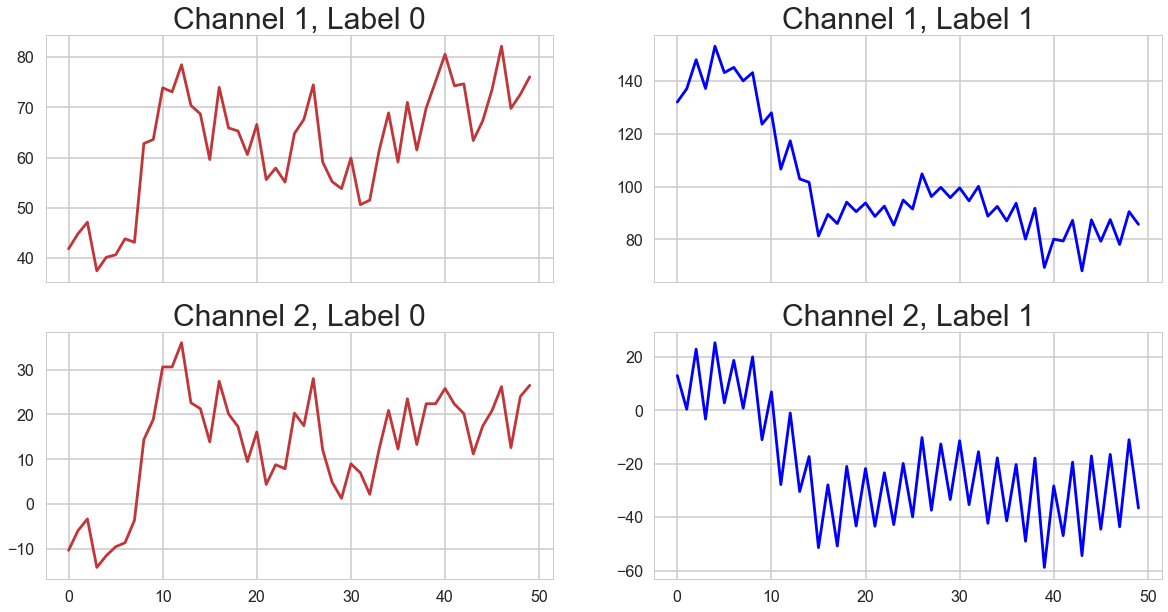

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(20,10), sharex=True)
ax[0, 0].plot(np.array(train_input[0, 0]))
ax[0, 0].set_title('Channel 1, Label {}'.format(train_target[0]), size=30)
ax[0, 1].plot(np.array(train_input[1, 0]), 'b')
ax[0, 1].set_title('Channel 1, Label {}'.format(train_target[1]), size=30)
ax[1, 0].plot(np.array(train_input[0, 1]))
ax[1, 0].set_title('Channel 2, Label {}'.format(train_target[0]), size=30)
ax[1, 1].plot(np.array(train_input[1, 1]), 'b')
ax[1, 1].set_title('Channel 2, Label {}'.format(train_target[1]), size=30)
fig.savefig("./dataset");

In [80]:
from scipy import signal
import numpy as np


def sampling(data, start, step):

    length = data.size()[2]
    sample = set(range(0, length, step))
    rest = set(range(length))
    data_ind = list(rest.difference(sample))
    return data_ind


def interpolation(data, data_len, start):

    x, y, z = data.size()
    data_new = np.zeros((x, y, data_len))
    data_ind = sampling(data, start, 8)
    data = data[:, :, data_ind]
    for i in range(x):
        for j in range(y):
            data_new[i, j] = signal.resample(data[i, j], data_len)
    return data_new

In [81]:
data_resample = interpolation(train_input, 50, 0)

In [82]:
ind = sampling(train_input[[0]], 0, 8)
a = np.array(interpolation(train_input, 50, 0)[0, 0])
b = np.zeros(50)
b[ind] = a[ind]

In [83]:
len(ind)

43

In [84]:
b

array([  0.        ,  45.88170239,  41.87654935,  35.71171222,
        42.70621162,  40.00347527,  44.46516902,  43.15036703,
         0.        ,  75.22124226,  70.41288812,  78.22866392,
        75.43568915,  70.26209702,  68.37937317,  59.99982205,
         0.        ,  67.90290145,  61.02353328,  63.19903181,
        65.49889486,  55.11338644,  57.41396478,  56.34627124,
         0.        ,  76.3950903 ,  68.15139094,  57.93417853,
        54.74483669,  53.40897057,  59.97912226,  53.61112104,
         0.        ,  68.00537935,  65.95562346,  59.55192323,
        70.71435817,  64.06192627,  63.3804773 ,  77.43424438,
         0.        ,  77.15932073,  72.63401672,  63.35144366,
        67.43119928,  68.87098577,  83.23660939,  74.54625881,
         0.        ,  73.25316381])

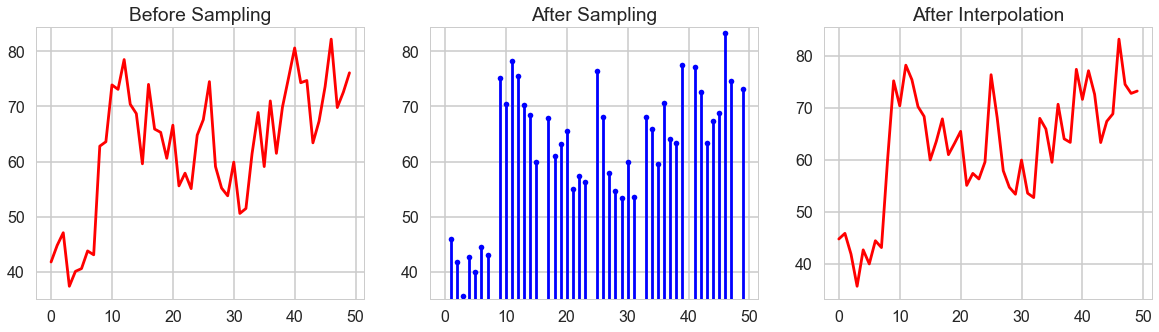

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(20,5), sharex=True)
ax[0].plot(np.array(train_input[0, 0]), 'r')
ax[0].set_title('Before Sampling')
ax[1].stem(b ,'b', '.b')
ax[1].set_title('After Sampling')
ax[1].set_ylim(ax[0].get_ylim())
ax[2].plot(np.array(interpolation(train_input, 50, 0)[0, 0]), 'r')
ax[2].set_title('After Interpolation')
fig.savefig("./aug");

In [89]:
ax[0].get_ylim()

(35.160001754760742, 84.439996719360352)

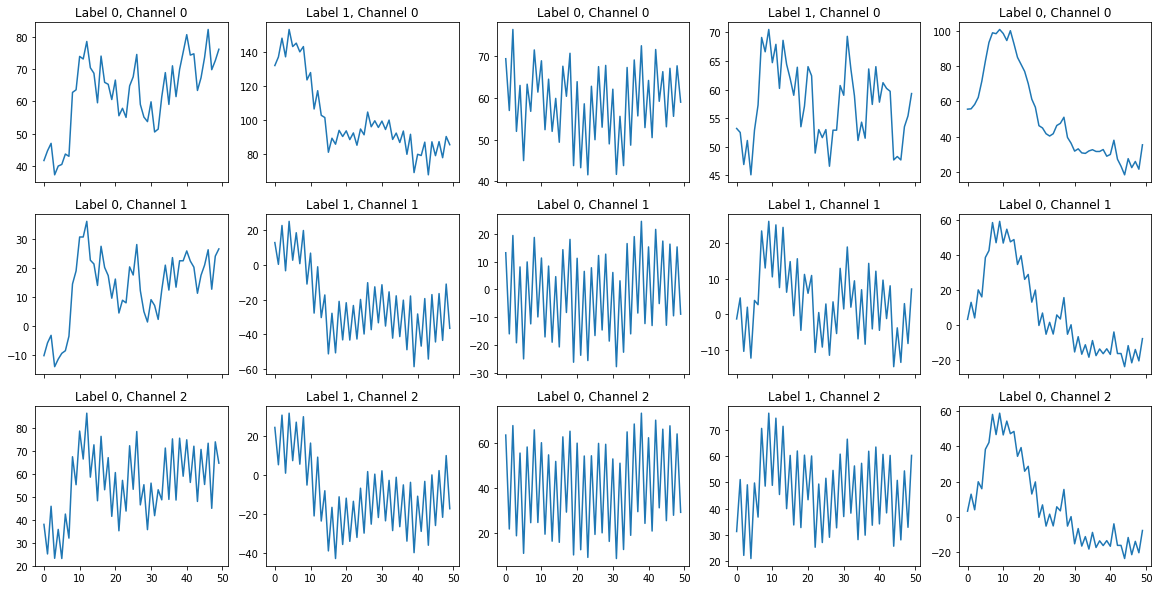

In [169]:
fig, ax = plt.subplots(3, 5, figsize=(20,10), sharex=True)
ax[0,0].plot(np.array(train_input[0, 0]))
ax[0,0].set_title('Label {}, Channel 0'.format(train_target[0]))
ax[0,1].plot(np.array(train_input[1, 0]))
ax[0,1].set_title('Label {}, Channel 0'.format(train_target[1]))
ax[0,2].plot(np.array(train_input[2, 0]))
ax[0,2].set_title('Label {}, Channel 0'.format(train_target[2]))

ax[1,0].plot(np.array(train_input[0, 1]))
ax[1,0].set_title('Label {}, Channel 1'.format(train_target[0]))
ax[1,1].plot(np.array(train_input[1, 1]))
ax[1,1].set_title('Label {}, Channel 1'.format(train_target[1]))
ax[1,2].plot(np.array(train_input[2, 1]))
ax[1,2].set_title('Label {}, Channel 1'.format(train_target[2]))

ax[2,0].plot(np.array(train_input[0, 2]))
ax[2,0].set_title('Label {}, Channel 2'.format(train_target[0]))

ax[2,1].plot(np.array(train_input[1, 2]))
ax[2,1].set_title('Label {}, Channel 2'.format(train_target[1]))

ax[2,2].plot(np.array(train_input[2, 2]))
ax[2,2].set_title('Label {}, Channel 2'.format(train_target[2]))

ax[0,3].plot(np.array(train_input[3, 0]))
ax[0,3].set_title('Label {}, Channel 0'.format(train_target[3]))
ax[1,3].plot(np.array(train_input[3, 1]))
ax[1,3].set_title('Label {}, Channel 1'.format(train_target[3]))
ax[2,3].plot(np.array(train_input[3, 2]))
ax[2,3].set_title('Label {}, Channel 2'.format(train_target[3]))

ax[0,4].plot(np.array(train_input[4, 0]))
ax[0,4].set_title('Label {}, Channel 0'.format(train_target[4]))
ax[1,4].plot(np.array(train_input[4, 1]))
ax[1,4].set_title('Label {}, Channel 1'.format(train_target[4]))
ax[2,4].plot(np.array(train_input[4, 1]))
ax[2,4].set_title('Label {}, Channel 2'.format(train_target[4]));

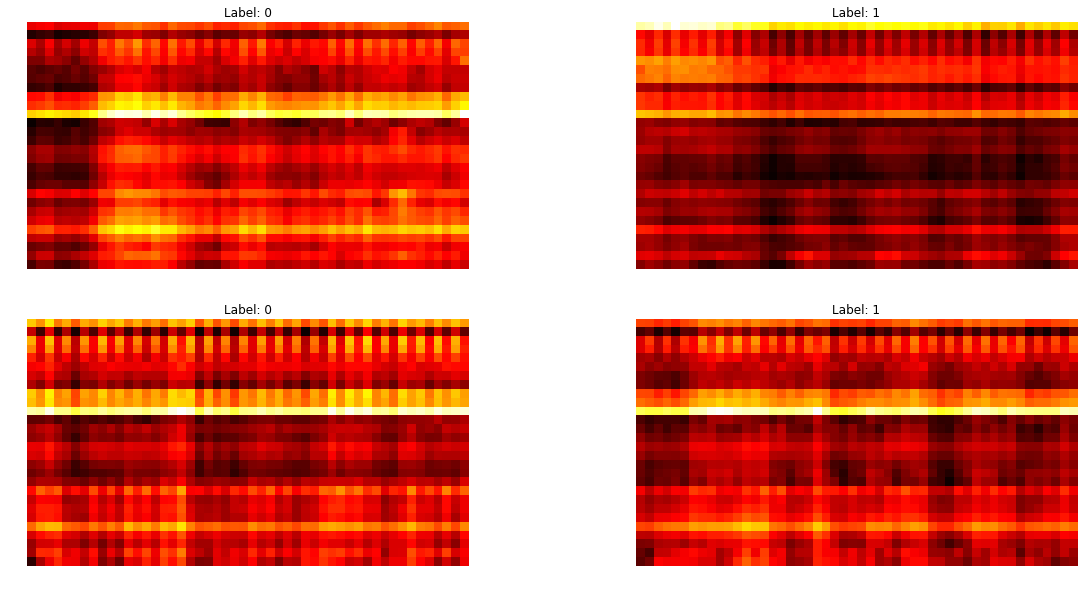

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0,0].imshow(np.array(train_input[0]), cmap='hot')
ax[0,0].set_title('Label: 0')
ax[0,0].axis('off')
ax[0,1].imshow(np.array(train_input[1]), cmap='hot')
ax[0,1].set_title('Label: 1')
ax[0,1].axis('off')
ax[1,0].imshow(np.array(train_input[2]), cmap='hot')
ax[1,0].set_title('Label: 0')
ax[1,0].axis('off')
ax[1,1].imshow(np.array(train_input[3]), cmap='hot')
ax[1,1].set_title('Label: 1')
ax[1,1].axis('off');

In [16]:
# TODO: Randomly choose train and test set #

In [160]:
# Normalization
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)
# convert to Variable
train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

## Support Vector Machine -- Baseline

In [6]:
X_train = train_input.view(316,-1)
y_train = train_target
X_test = test_input.view(100,-1)
y_test = test_target

In [7]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train.data, y_train.data)
clf.score(X_test.data, y_test.data)

0.75

In [118]:
clf = linear_model.LogisticRegression()
clf.fit(X_train.data, y_train.data)
clf.score(X_test.data, y_test.data)

0.71999999999999997

# Neural Network

train_input = train_input.view(316,1,28,50)
test_input = test_input.view(100,1,28,50)

class Net_2D(nn.Module):
    def __init__(self):
        super(Net_2D, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 30, kernel_size=(4,4))
        self.conv1_drop = nn.Dropout(0.8)
        self.conv2 = nn.Conv2d(30, 60, kernel_size=(2,2))
        self.conv2_drop = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(120,60)
        self.fc2 = nn.Linear(60,40)
        self.fc3 = nn.Linear(40,20)
        self.fc4 = nn.Linear(20,10)
        self.fc5 = nn.Linear(10,5)
        self.fc6 = nn.Linear(5,2)
        
    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.conv1_drop(x)
        x = F.max_pool2d(x, 4)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 4)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        x = F.softmax(self.fc6(x), 1)
        return x

### Simple Model

In [134]:
class Net_1D(nn.Module):
    def __init__(self):
        super(Net_1D, self).__init__()
        self.conv1 = nn.Conv1d(28, 64, kernel_size=5)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        
        self.fc1 = nn.Linear(640,160)
        self.fc2 = nn.Linear(160,40)
        self.fc3 = nn.Linear(40,20)
        self.fc4 = nn.Linear(20,2)
    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 3)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        
        x = F.softmax(self.fc4(x), 1)
        
        return x

In [136]:
model = Net_1D()
print(model(train_input).shape)

torch.Size([3160, 2])


In [151]:
def train_model(model, train_input, train_target):
    lr, nb_epochs, mini_batch_size = 1e-1, 100, 316
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0) # lr=1e-1
    
    criterion = torch.nn.CrossEntropyLoss()
    errors = []
    losses = []
    for k in range(nb_epochs):
        model.train()
        
        for b in range(0, train_input.size(0), mini_batch_size): 
            optimizer.zero_grad()
            output = model(train_input.narrow(0, b, mini_batch_size)) 
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            loss.backward()
            optimizer.step()
        
        model.eval()
        output_eval = model(train_input)
        loss_eval = criterion(output_eval, train_target)
        pred = output_eval.data.max(1, keepdim=True)[1]
        error = pred.ne(train_target.data.view_as(pred)).sum()
        if k%10==0 : print(k, error, loss_eval.data[0])
        errors.append(error)
        losses.append(loss_eval.data[0])
    return errors, losses

In [152]:
def compute_nb_errors(model, data_input, data_target):
    model.eval()
    nb_errors = 0
    output = model.forward(data_input)
    pred = output.data.max(1, keepdim=True)[1]
    nb_errors = pred.ne(data_target.data.view_as(pred)).sum()
    return nb_errors

In [ ]:
model = Net_1D()

errors, losses = train_model(model, train_input, train_target)


Train Error: 0.32%
Test Error: 35.00%


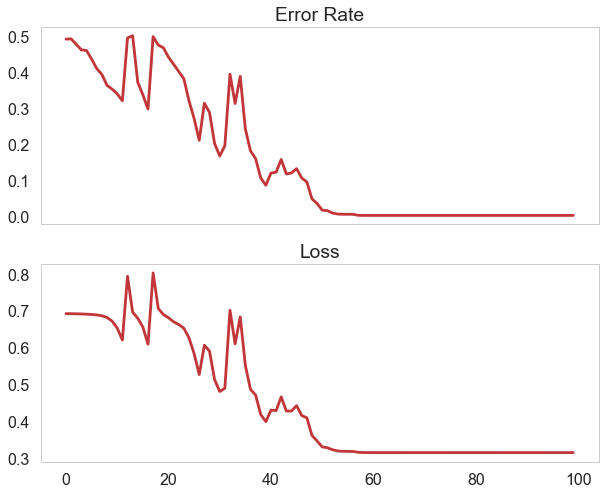

In [161]:
train_error = compute_nb_errors(model, train_input, train_target)
print('Train Error: {:.2%}'.format(train_error/train_input.size(0)))
test_error = compute_nb_errors(model, test_input, test_target)
print('Test Error: {:.2%}'.format(test_error/test_input.size(0)))

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[0].plot(np.array(errors)/train_input.size(0))
ax[0].set_title("Error Rate")
ax[0].grid()
ax[1].plot(np.array(losses))
ax[1].set_title("Loss")
ax[1].grid()
plt.show();

In [ ]:
# Try data augmentaion 
# Use overlapping window
# Unfinished

In [657]:
def data_aug(data, target):
    data_aug = []
    target_aug = []
    for i in range(data.shape[0]):
        data_aug.append(data[i,:,0:20].tolist())
        data_aug.append(data[i,:,15:35].tolist())
        data_aug.append(data[i,:,30:50].tolist())
        for j in range(3):
            target_aug.append(target[i])
    return Variable(torch.Tensor(data_aug)), Variable(torch.LongTensor(target_aug))

In [658]:
train_input_aug, train_target_aug = data_aug(train_input.data, train_target.data)
test_input_aug, test_target_aug = data_aug(test_input.data, test_target.data)

In [71]:
class Net_1D(nn.Module):
    def __init__(self):
        super(Net_1D, self).__init__()
        
        self.conv1 = nn.Conv1d(28, 64, kernel_size=4)
        #self.conv1_bn = nn.BatchNorm2d(64)
        #self.conv1_drop = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=4)
        #self.conv2_bn = nn.BatchNorm2d(128)
        #self.conv2_drop = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(512,256)
        #self.fc1_bn = nn.BatchNorm1d(160)
        #self.fc1_drop = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256,128)
        #self.fc2_bn = nn.BatchNorm1d(20)
        self.fc2_drop = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128,32)
        self.fc3_drop = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(32,16)
        self.fc4_drop = nn.Dropout(0.3)
        
        self.fc5 = nn.Linear(16,2)
    
    def forward(self, x): 
        
        #x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 3)
        x = self.conv1_drop(x)
        
        
        #x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 3)
        x = self.conv2_drop(x)
        
        x = x.view(x.size(0), -1)
        
        #x = F.relu(self.fc1_bn(self.fc1(x)))
        #x = F.relu(self.fc1(x))
        #x = self.fc1_drop(x)
        
        #x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        
        x = F.relu(self.fc3(x))
        x = self.fc3_drop(x)
        
        x = F.relu(self.fc4(x))
        x = self.fc4_drop(x)
        
        x = F.softmax(self.fc5(x), 1)
        return x

In [72]:
# test the structure
model = Net_1D()
print(model(train_input_aug).shape)

NameError: name 'train_input_aug' is not defined

In [10]:
def train_model(model, train_input, train_target):
    lr, nb_epochs = 1e-2, 300
    #optimizer = optim.ASGD(model.parameters(), lr=lr, weight_decay=1e-1) # lr=1e-1
    #optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0) # lr=1e-1
    #optimizer = optim.Adadelta(model.parameters(), lr=lr, weight_decay=1e-3) # lr=1e-1
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0) # lr=1e-3

    #scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=1e-1)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)
    
    criterion = torch.nn.CrossEntropyLoss()
    errors = []
    losses = []
    for k in range(nb_epochs):
        model.train()
        scheduler.step()
        
        optimizer.zero_grad()
        output = model(train_input) 
        loss = criterion(output, train_target)
        loss.backward()
        optimizer.step()
        
        model.eval()
        output_eval = model(train_input)
        loss_eval = criterion(output_eval, train_target)
        pred = output_eval.data.max(1, keepdim=True)[1]
        error = pred.ne(train_target.data.view_as(pred)).sum()
        if k%10==0 : print(k, error, loss_eval.data[0])
        errors.append(error)
        losses.append(loss_eval.data[0])
    return errors, losses

0 478 0.6930677890777588
10 381 0.6744322776794434
20 337 0.6399544477462769
30 383 0.6689212322235107
40 286 0.61095130443573
50 267 0.5834888815879822
60 242 0.5657204985618591
70 232 0.5505910515785217
80 257 0.571182131767273
90 218 0.536892831325531
100 204 0.5115031599998474
110 199 0.5122100114822388
120 196 0.5114665031433105
130 222 0.5307415723800659
140 198 0.5070069432258606
150 157 0.4688580334186554
160 131 0.4559779763221741
170 144 0.46348774433135986
180 145 0.4600653052330017
190 122 0.44289925694465637
200 105 0.42745453119277954
210 140 0.45579221844673157
220 128 0.44582417607307434
230 120 0.43634891510009766
240 112 0.4276721179485321
250 108 0.42521876096725464
260 84 0.4037967026233673
270 113 0.42942366003990173
280 114 0.4316282868385315
290 122 0.43924254179000854
Correct: 60.33%


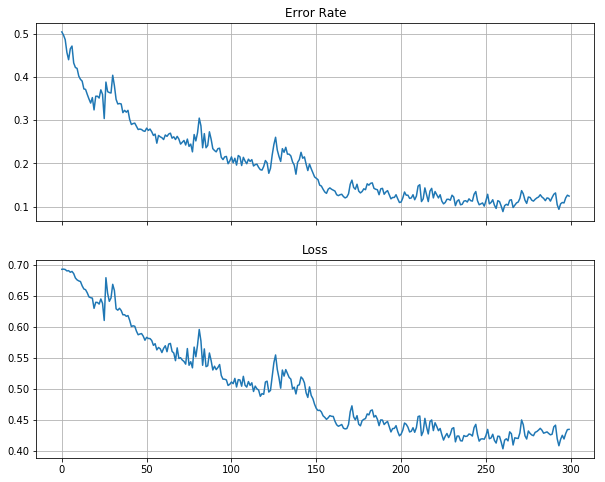

In [706]:
model = Net_1D()

errors, losses = train_model(model, train_input_aug, train_target_aug)

nb_error = compute_nb_errors(model, test_input_aug, test_target_aug)
print('Correct: {:.2%}'.format(1-nb_error/test_input_aug.size(0)))

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[0].plot(np.array(errors)/train_input_aug.size(0))
ax[0].set_title("Error Rate")
ax[0].grid()
ax[1].plot(np.array(losses))
ax[1].set_title("Loss")
ax[1].grid()
plt.show();

In [95]:
train_input = train_input.view(316,28,50)
test_input = test_input.view(100,28,50)

In [212]:
class Net_1D(nn.Module):
    def __init__(self):
        super(Net_1D, self).__init__()
        
        self.conv1 = nn.Conv1d(28, 128, kernel_size=5)
        self.conv1_bn = nn.BatchNorm1d(128)
        self.conv1_drop = nn.Dropout(0.5)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5)
        self.conv2_bn = nn.BatchNorm1d(128)
        self.conv2_drop = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(640,160)
        self.fc1_bn = nn.BatchNorm1d(160)
        self.fc1_drop = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(160,40)
        self.fc2_bn = nn.BatchNorm1d(40)
        self.fc2_drop = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(1920,320)
        self.fc3_bn = nn.BatchNorm1d(320)
        self.fc3_drop = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(320,2)
        
    def forward(self, x): 
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
#         x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 3)
        x = self.conv1_drop(x)
        
        
#         x = F.relu(self.conv2_bn(self.conv2(x)))
# #         x = F.relu(self.conv2(x))
#         x = F.max_pool1d(x, 4)
#         x = self.conv2_drop(x)
        
        x = x.view(x.size(0), -1)
        
#         x = F.relu(self.fc1_bn(self.fc1(x)))
# #         x = F.relu(self.fc1(x))
#         x = self.fc1_drop(x)
        
#         x = F.relu(self.fc2_bn(self.fc2(x)))
# #         x = F.relu(self.fc2(x))
#         x = self.fc2_drop(x)
    
        x = F.relu(self.fc3_bn(self.fc3(x)))
#         x = F.relu(self.fc2(x))
#         x = self.fc3_drop(x)
        
        x = F.softmax(self.fc4(x), 1)
        return x

In [213]:
# test the structure
model = Net_1D()
print(model(train_input).shape)

torch.Size([3160, 2])


In [220]:
def train_model(model, train_input, train_target):
    lr, nb_epochs, mini_batch_size = 5e-1, 100, 316
    #optimizer = optim.ASGD(model.parameters(), lr=lr, weight_decay=1e-1) # lr=1e-1
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-1) # lr=1e-1
    #optimizer = optim.Adadelta(model.parameters(), lr=lr, weight_decay=1e-3) # lr=1e-1
    optimizer = optim.Adam(model.parameters(), lr=lr) # lr=1e-3

    #scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=1e-1)
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.02, threshold=1e-4, eps=1e-9)
    
    criterion = torch.nn.CrossEntropyLoss()
    errors = []
    losses = []
#     metric = np.inf
    for k in range(nb_epochs):
        model.train()
#         scheduler.step(metric)


        for b in range(0, train_input.size(0), mini_batch_size): 
            optimizer.zero_grad()
            output = model(train_input.narrow(0, b, mini_batch_size)) 
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            loss.backward()
            optimizer.step()
        
        model.eval()
        output_eval = model(train_input)
        loss_eval = criterion(output_eval, train_target)
        pred = output_eval.data.max(1, keepdim=True)[1]
        error = pred.ne(train_target.data.view_as(pred)).sum()
        if k%10==0 : print(k, error, loss_eval.data[0])
        errors.append(error)
        losses.append(loss_eval.data[0])

    return errors, losses

In [221]:
def compute_nb_errors(model, data_input, data_target):
    model.eval()
    nb_errors = 0
    output = model.forward(data_input)
    pred = output.data.max(1, keepdim=True)[1]
    nb_errors = pred.ne(data_target.data.view_as(pred)).sum()
    return nb_errors

In [ ]:
model = Net_1D()

errors, losses = train_model(model, train_input, train_target)

nb_error = compute_nb_errors(model, test_input, test_target)
print('Correct: {:.2%}'.format(1-nb_error/test_input.size(0)))

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[0].plot(np.array(errors)/train_input.size(0))
ax[0].set_title("Error Rate")
ax[0].grid()
ax[1].plot(np.array(losses))
ax[1].set_title("Loss")
ax[1].grid()
plt.show();

0 1647 0.8343210220336914
10 1590 0.8164030909538269
20 1590 0.8164030909538269
30 1590 0.8164030909538269
40 1590 0.8164030909538269
50 1590 0.8164030909538269
60 1590 0.8164030909538269
70 1590 0.8164030909538269
80 1590 0.8164030909538269
